In [14]:
import pandas as pd

df = pd.read_csv("../notebooks/data/dataset.csv")

In [15]:
pd.options.display.max_columns = None

## Extraction des caractéristiques personnalisées basée sur la structure de l'URL

J'ai utilisé diverses techniques pour analyser la structure, le contenu et les caractéristiques d'une URL afin de créer des caractéristiques qui peuvent être utilisées par un modèle d'apprentissage automatique. Plusieurs de ces fonctionnalités tirent leur inspiration de notebooks  provenant de compétitions Kaggle précédentes.

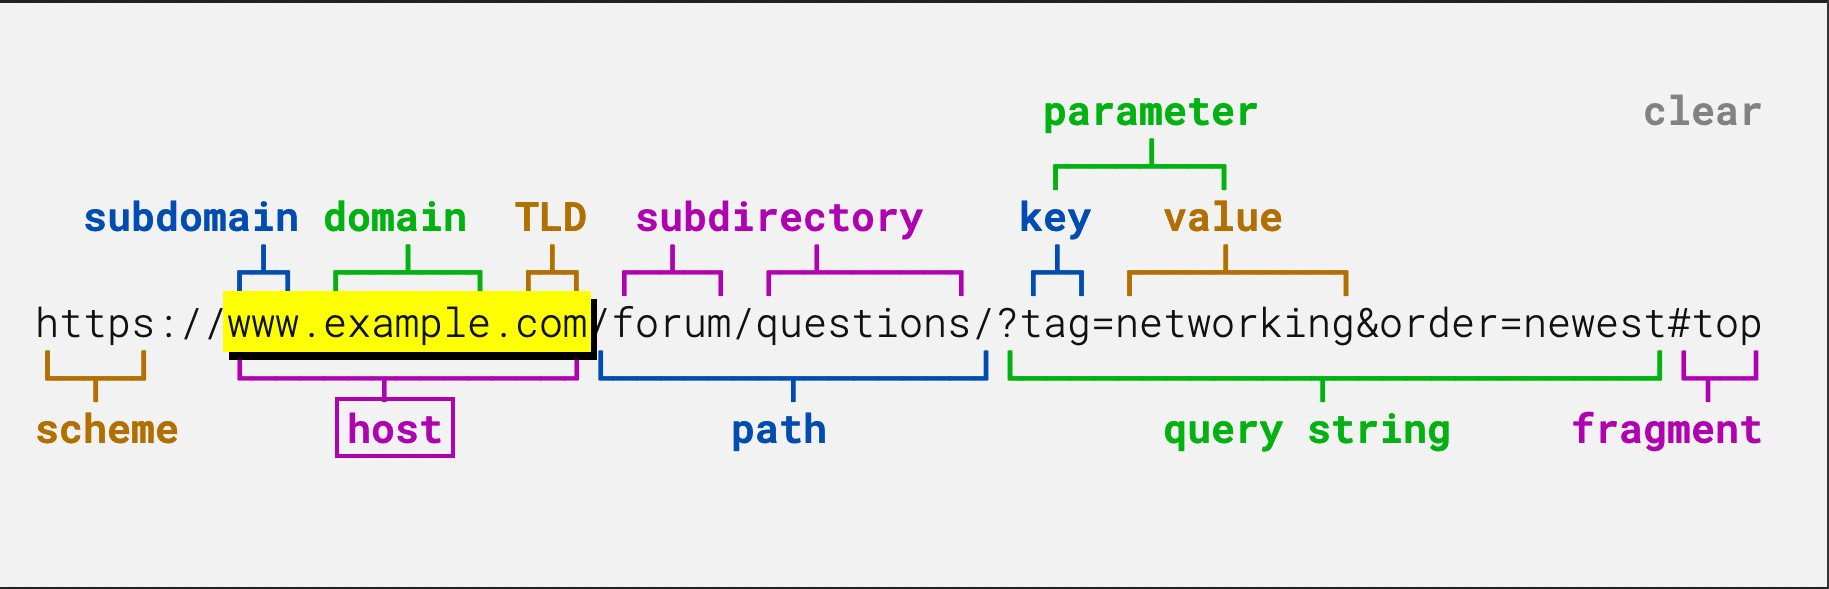
## Logique d'extraction des caractéristiques

1. **Caractéristiques de base de l'URL :**
   - `url_length` : La longueur de la chaîne d'URL.
   - `hostname_length` : La longueur du nom d'hôte (par exemple, « www.google.com »).
   - `path_length` : La longueur du composant de chemin (par exemple, « /search »).
   - `num_subdomains` : Le nombre de sous-domaines dans l'URL (par exemple, « www.google.com » a un sous-domaine).
   - `domain_length` : La longueur du nom de domaine (par exemple, « google.com »).
   - `suffix_length` : La longueur du suffixe (par exemple, « .com »).

2. **Caractéristiques de densité des caractères :**
   - `digit_density` : La proportion de chiffres dans l'URL.
   - `letter_density` : La proportion de lettres dans l'URL.
   - `special_char_density` : La proportion de caractères spéciaux dans l'URL.
   - `uppercase_density` : La proportion de lettres majuscules dans l'URL.
   - `lowercase_density` : La proportion de lettres minuscules dans l'URL.

3. **Présence d'éléments spécifiques :**
   - `has_https` : 1 si l'URL utilise HTTPS, 0 sinon.
   - `has_www` : 1 si l'URL contient « www », 0 sinon.
   - `has_ip_address` : 1 si l'URL contient une adresse IP, 0 sinon.

4. **Autres caractéristiques de l'URL :**
   - `num_slashes` : Le nombre de barres obliques dans l'URL.
   - `query_length` : La longueur de la chaîne de requête (la partie après « ? »).
   - `has_query` : 1 si l'URL a une chaîne de requête, 0 sinon.
   - `vowel_density` : La proportion de voyelles dans l'URL.
   - `consonant_density` : La proportion de consonnes dans l'URL.

5. **Entropie :**
   - `entropy` : Une mesure de l'aléatoire et de la complexité de l'URL. Une valeur d'entropie plus élevée suggère une URL plus complexe et potentiellement suspecte.

6. **Mots de phishing :**
   - `has_phishing_words` : 1 si l'URL contient l'un des mots de phishing spécifiés, 0 sinon.
   - `phishing_word_count` : Le nombre de mots de phishing trouvés dans l'URL.
   - `phishing_word_density` : La proportion de mots de phishing dans l'URL.

## Bibliothèques
- `urllib.parse.urlparse` : Cette bibliothèque est utilisée pour analyser l'URL en ses composants (schéma, netloc, chemin, etc.).
- `tldextract` : Cette bibliothèque permet d'extraire le sous-domaine, le domaine et le suffixe de l'URL.
- `re` : La bibliothèque d'expressions régulières est utilisée pour identifier les adresses IP dans l'URL.
- `numpy` : numpy est utilisé pour le calcul de l'entropie.

En extrayant ces caractéristiques, nous pouvons construire un modèle qui peut potentiellement distinguer les sites web légitimes des sites de phishing en fonction de ces caractéristiques.

In [6]:
import pandas as pd
from urllib.parse import urlparse
import tldextract
import logging
import numpy as np
import itertools

# Configure logging
logging.basicConfig(level=logging.INFO)

def extract_features(url):
    """Extracts features from a URL."""
    features = {}
    
    try:
        parsed_url = urlparse(url)
        extracted = tldextract.extract(url)
    except Exception as e:
        logging.error(f"Error parsing URL {url}: {e}")
        return {}
    
    # URL Length
    features["url_length"] = len(url)
    features["hostname_length"] = len(parsed_url.netloc)
    features["path_length"] = len(parsed_url.path)

    # Domain
    features["num_subdomains"] = len(extracted.subdomain.split(".")) if extracted.subdomain else 0
    features["domain_length"] = len(extracted.domain)
    features["suffix_length"] = len(extracted.suffix)

    # Character Density
    features["digit_density"] = sum(c.isdigit() for c in url) / len(url) if len(url) > 0 else 0
    features["letter_density"] = sum(c.isalpha() for c in url) / len(url) if len(url) > 0 else 0
    features["special_char_density"] = sum(not c.isalnum() for c in url) / len(url) if len(url) > 0 else 0
    features["uppercase_density"] = sum(c.isupper() for c in url) / len(url) if len(url) > 0 else 0
    features["lowercase_density"] = sum(c.islower() for c in url) / len(url) if len(url) > 0 else 0

    # Protocol and Subdomain
    features["has_https"] = int(parsed_url.scheme == "https")
    features["has_www"] = int("www" in url.lower())

    # Suspicious Words
    features["num_slashes"] = url.count("/")
    features["query_length"] = len(parsed_url.query)
    features["has_query"] = int(bool(parsed_url.query))

    # Vowel and Consonant Density
    features["vowel_density"] = sum(1 for c in url if c in "aeiouAEIOU") / len(url) if len(url) > 0 else 0
    features["consonant_density"] = sum(1 for c in url if c.isalpha() and c.lower() not in "aeiou") / len(url) if len(url) > 0 else 0

    # Entropy
    char_counts = [url.count(c) for c in set(url)]
    features["entropy"] = -sum((np.array(char_counts) / len(url)) * np.log(np.array(char_counts) / len(url)))

    # Phishing Words
    phishing_words = [
        "paypal", "login", "signin", "verify", "account", "update", "payment", 
        "bank", "secure", "alert", "confirm", "password", "financial", "webscr", 
        "submit"
    ]
    features["has_phishing_words"] = int(any(word in url.lower() for word in phishing_words))
    features["phishing_word_count"] = sum(url.lower().count(word) for word in phishing_words)
    features["phishing_word_density"] = features["phishing_word_count"] / len(url) if len(url) > 0 else 0

    # Additional Features
    features["num_dashes"] = url.count("-")
    features["num_dots"] = url.count(".")
    features["num_at_symbols"] = url.count("@")
    features["num_and_symbols"] = url.count("&")
    features["num_equals_symbols"] = url.count("=")
    features["num_underscore_symbols"] = url.count("_")

    # Check for IP address in the domain
    features["is_ip"] = int(any(char.isdigit() for char in extracted.domain.split('.')))

    # Additional Out-of-the-Box Features
    features["has_port"] = int(parsed_url.port is not None)
    features["has_fragment"] = int(bool(parsed_url.fragment))
    features["has_params"] = int(bool(parsed_url.params))
    features["has_username"] = int(bool(parsed_url.username))
    features["has_password"] = int(bool(parsed_url.password))
    features["has_hexadecimal"] = int(any(c in "0123456789abcdefABCDEF" for c in url))
    features["has_base64"] = int(any(c in "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+/=" for c in url))
    features["has_unicode"] = int(any(ord(c) > 127 for c in url))
    
    # Count of different characters
    features["unique_chars_count"] = len(set(url))
    
    # Ratio of unique characters to total length
    features["unique_chars_ratio"] = len(set(url)) / len(url) if len(url) > 0 else 0
    
    # Presence of common TLDs (.com,.net,.org)
    common_tlds = ["com", "net", "org"]
    features["common_tld"] = int(extracted.suffix in common_tlds)
    
    
    # Number of hyphens in the domain part
    features["hyphens_in_domain"] = extracted.domain.count('-')
    
    # Number of digits in the path
    features["digits_in_path"] = sum(c.isdigit() for c in parsed_url.path)
    
    # Number of uppercase letters in the query
    features["uppercase_in_query"] = sum(c.isupper() for c in parsed_url.query)
    
    # Presence of email-related keywords
    email_keywords = ["mail", "email", "@", "inbox", "sent", "spam"]
    features["has_email_keywords"] = int(any(keyword in url.lower() for keyword in email_keywords))
    
    # Presence of redirection-related keywords
    redirect_keywords = ["redirect", "forward", "go", "move", "jump"]
    features["has_redirect_keywords"] = int(any(keyword in url.lower() for keyword in redirect_keywords))
    
    # Presence of double slashes in the path
    features["double_slash_in_path"] = "//" in parsed_url.path
    
    # Presence of mixed case in the domain
    features["mixed_case_domain"] = int(any(c.isupper() for c in extracted.domain) and any(c.islower() for c in extracted.domain))
    
    return features

# Extract features and load into a DataFrame
df_features = pd.DataFrame([extract_features(df["domain"].iloc[i]) for i in range(len(df))])

In [7]:
df_features.shape

(120990, 47)

In [8]:
df_features.describe().T

,count,mean,std,min,25%,50%,75%,max
url_length,120990.0,66.626126,55.768589,4.000000,29.000000,46.000000,94.000000,2175.000000
hostname_length,120990.0,3.451922,5.627661,0.000000,0.000000,0.000000,9.000000,23.000000
path_length,120990.0,51.225407,39.251308,1.000000,27.000000,40.000000,69.000000,2175.000000
num_subdomains,120990.0,0.751012,1.543829,0.000000,0.000000,0.000000,1.000000,33.000000
domain_length,120990.0,7.976196,4.081250,0.000000,5.000000,8.000000,10.000000,63.000000
suffix_length,120990.0,2.957434,1.004329,0.000000,3.000000,3.000000,3.000000,11.000000
digit_density,120990.0,0.076135,0.107293,0.000000,0.000000,0.027027,0.115385,0.763158
letter_density,120990.0,0.766257,0.121578,0.086957,0.713450,0.800000,0.851852,0.984368
special_char_density,120990.0,0.157608,0.050023,0.012821,0.128056,0.153846,0.181818,0.461538
uppercase_density,120990.0,0.023942,0.059469,0.000000,0.000000,0.000000,0.000000,0.870968


In [10]:
df_features["label"] = df["label"]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

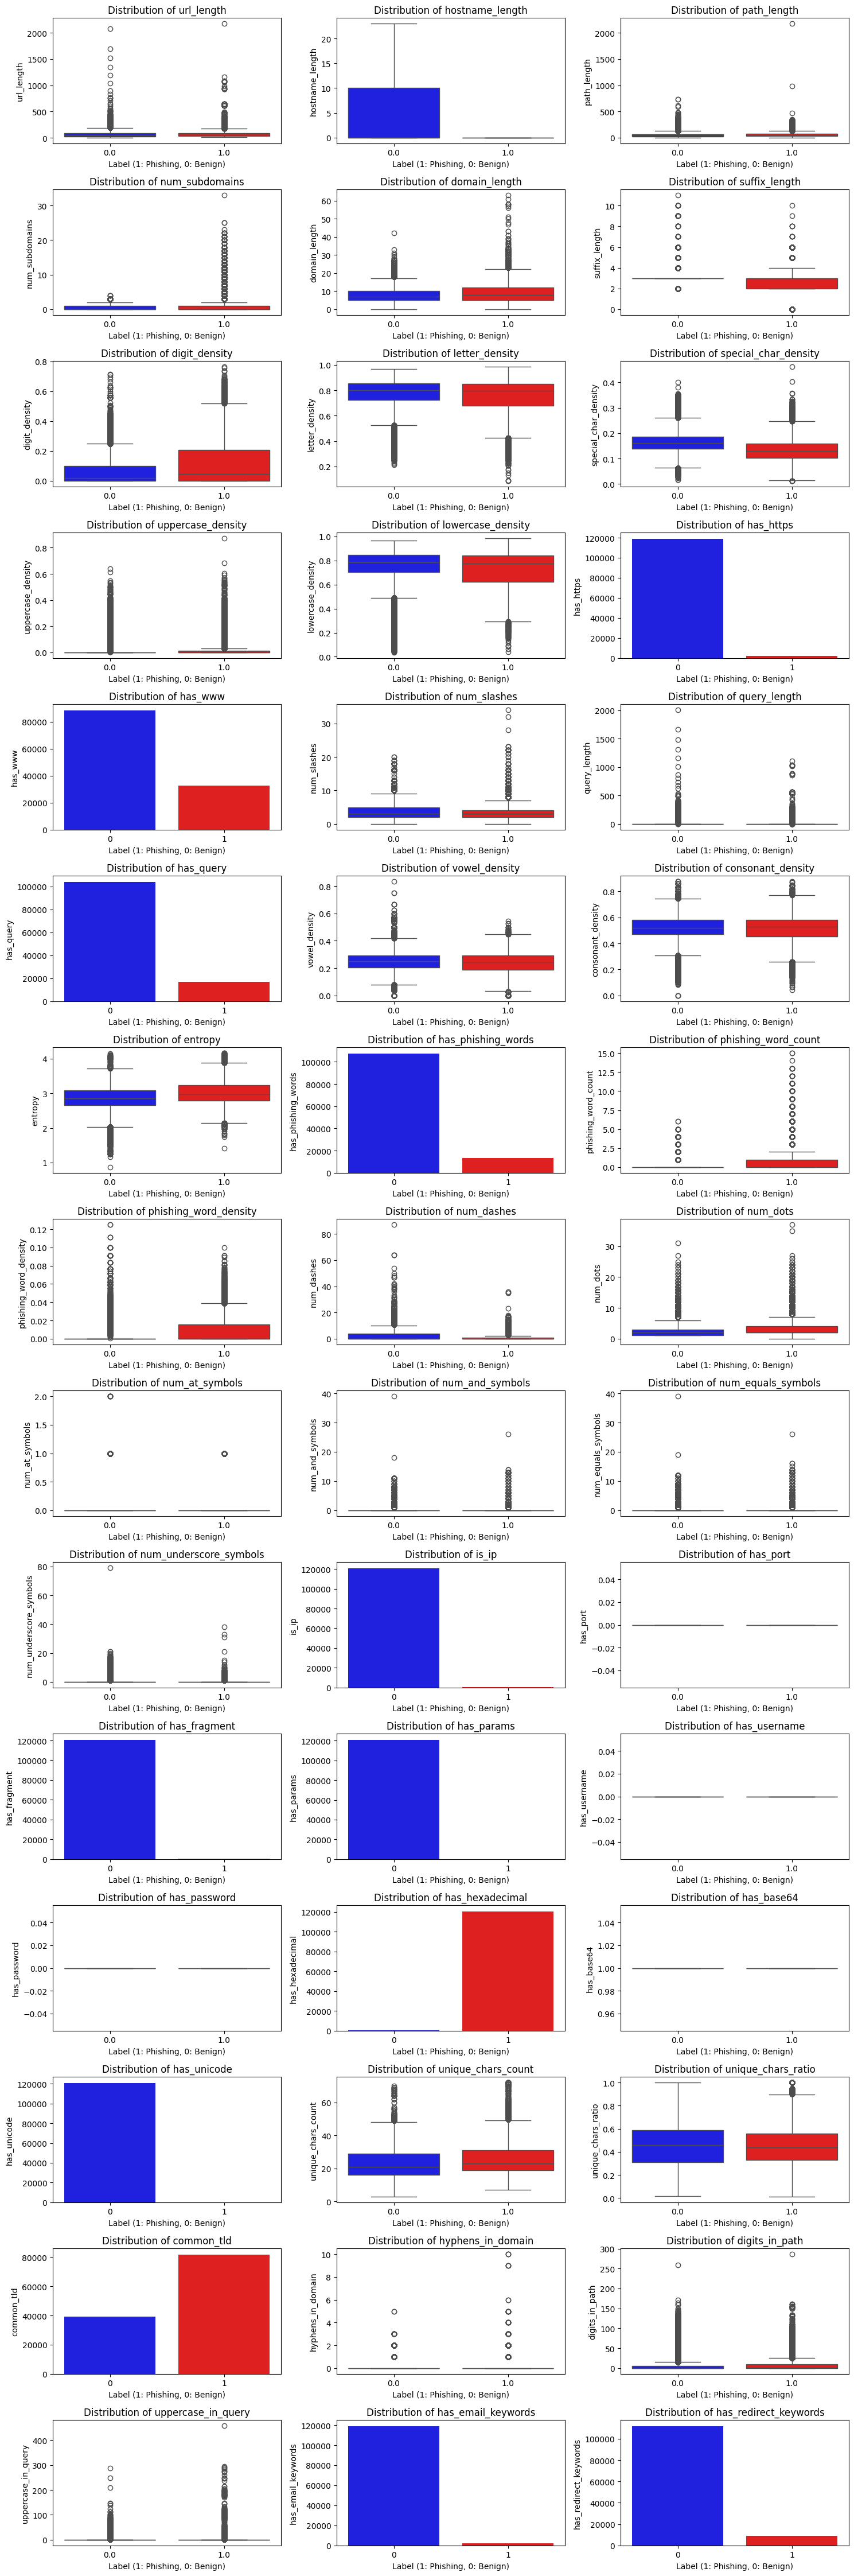

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

nrows = 15
ncols = 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
axes = axes.flatten()

# Plot the features distribution
for i, feature in enumerate(df_features):
    if i < len(axes):
        if df_features[feature].nunique() == 2:
            sns.countplot(x=feature, data=df_features, ax=axes[i], palette=["b", "r"], legend=False)
        else:
            sns.boxplot(x="label", y=feature, hue="label", data=df_features, ax=axes[i], palette=["b", "r"], legend=False)
        axes[i].set_title(f"Distribution of {feature}")
        axes[i].set_xlabel("Label (1: Phishing, 0: Benign)")
        axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

 Certaines caractéristiques, comme la longueur de l'URL, la densité de chiffres, le nombre de mots de phishing et la densité de mots de phishing, montrent des différences notables entre les URL de phishing et les URL légitimes, suggérant leur forte puissance prédictive. Même si d'autres caractéristiques ne fournissent peut-être pas une séparation aussi claire, elles pourraient néanmoins contribuer à la performance de classification globale du modèle.

In [12]:
# save custome features for testing
df_features.to_csv("../notebooks/data/custom_features.csv", index=False)

## Extraction des caractéristiques à l'aide de la tokenisation

La tokenisation et la racinisation (stemming), essentielles à l'identification et à la normalisation des mots-clés dans les URL, ont été exploitées pour extraire des caractéristiques utiles pour détecter les sites de phishing. Ces méthodes révèlent les tendances dans la structuration des URL par les cybercriminels. La tokenisation scinde une URL en segments significatifs à l'aide de délimiteurs, tandis que le stemming réduit les mots à leur forme de base pour une comparaison plus efficace.

Étapes pour l'extraction des *features*

#### 1. Vectorisation des domaines
Le `CountVectorizer` vectorise les domaines, mettant en évidence des mots critiques dans les URL, comme « virus » ou « .exe », par le biais d'un modèle de tokenisation spécifique.

#### 2. Utilisation de RegexpTokenizer
Le `RegexpTokenizer` utilise une expression régulière pour isoler les tokens et faciliter leur traitement ultérieur.

#### 3. Prétraitement des URL
Le texte brut est transformé en tokens normalisés grâce à la tokenisation et au stemming. Ce dernier regroupe les mots par racine commune, aidant à reconnaître des variantes orthographiques du même terme.

#### 4. Application au dataframe
Le prétraitement est appliqué aux URLs du dataframe

#### 5. Préparation du CountVectorizer
On ajuste le `CountVectorizer` à l'ensemble du texte pour former un lexique de termes fréquents qui sera utilisé pour la représentation vectorielle des URLs.

#### 6. Extraction de caractéristiques
On utilise une fonction d'extraction pour obtenir des caractéristiques des URLs, y compris celles dérivées via le `CountVectorizer`. C

Référence :
https://www.kaggle.com/datasets/taruntiwarihp/phishing-site-urls/code
https://www.mdpi.com/2076-3417/13/9/5275

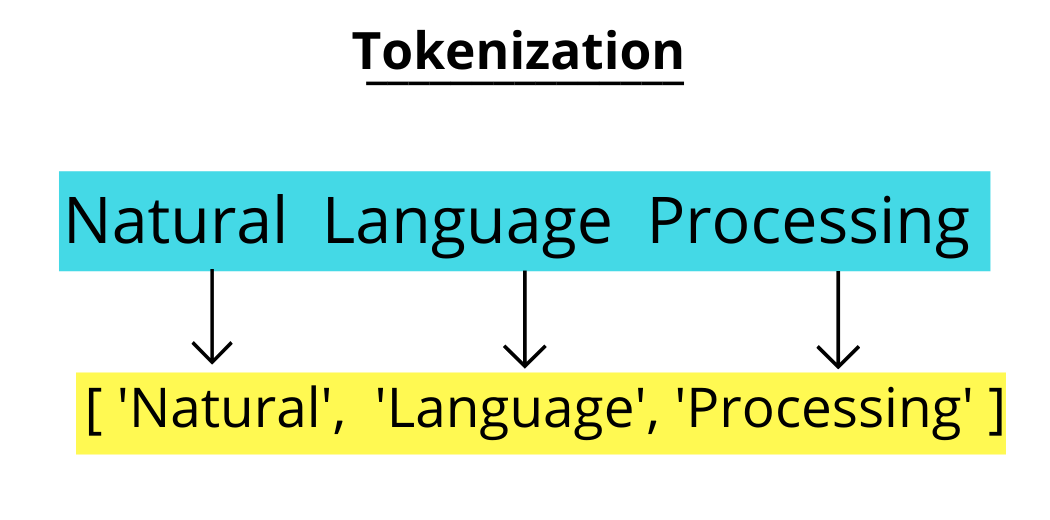
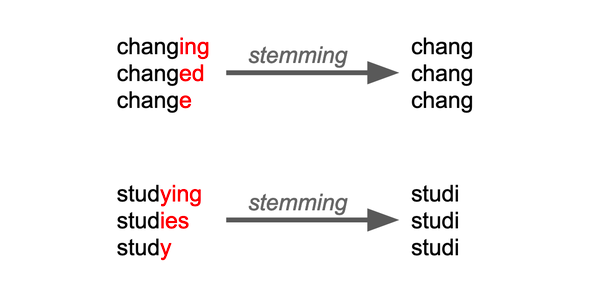

In [40]:
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
import pickle

stemmer = SnowballStemmer("english")
tokenizer = RegexpTokenizer(r"[A-Za-z]+")

# preprocess the text for all our domains.
def preprocess_text(url):
    """Tokenize and stem the text of a URL."""
    tokens = tokenizer.tokenize(url)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return " ".join(stemmed_tokens)

df["text_processed"] = df["domain"].apply(preprocess_text)

# fit a CountVectorizer to all our preprocessed text.
cv = CountVectorizer(max_features=25, ngram_range=(1, 3))
cv.fit(df["text_processed"]) 

def extract_features(row):
    """Extract features, including NLP features."""
    text_processed = row["text_processed"]
    features = {}
    
    # get NLP features using the fitted CountVectorizer.
    text_features = cv.transform([text_processed])
    text_features_dict = {f"nlp_{i}": val for i, val in enumerate(text_features.toarray()[0])}
    features.update(text_features_dict)
    
    # save the fitted CountVectorizer
    pickle.dump(cv, open("../notebooks/models/cv.pkl", "wb"))

    return features

# apply feature extraction to the DataFrame.
df_tokenizer_features = pd.DataFrame(df.apply(extract_features, axis=1).tolist())

In [21]:
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Initialize stemmer and tokenizer
stemmer = SnowballStemmer("english")
tokenizer = RegexpTokenizer(r"[A-Za-z]+")

# Preprocess the text for all our domains
def preprocess_text(url):
    """Tokenize and stem the text of a URL."""
    tokens = tokenizer.tokenize(url)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return " ".join(stemmed_tokens)

df["text_processed"] = df["domain"].apply(preprocess_text)

# Initialize the TensorFlow Tokenizer
tf_tokenizer = Tokenizer(num_words=100, oov_token="<OOV>")
tf_tokenizer.fit_on_texts(df["text_processed"])

# Save the fitted tokenizer
with open("tf_tokenizer.pkl", "wb") as file:
    pickle.dump(tf_tokenizer, file)

# Function to extract features using the fitted Tokenizer
def extract_features(row):
    """Extract features, including NLP features."""
    text_processed = row["text_processed"]
    features = {}
    
    # Transform the text using the fitted Tokenizer
    text_sequences = tf_tokenizer.texts_to_sequences([text_processed])
    text_padded = pad_sequences(text_sequences, maxlen=20, padding='post')
    
    # Convert the padded sequences to a dictionary of features
    text_features_dict = {f"nlp_{i}": val for i, val in enumerate(text_padded[0])}
    features.update(text_features_dict)
    
    return features

# Apply feature extraction to the DataFrame
df_tokenizer_features = pd.DataFrame(df.apply(extract_features, axis=1).tolist())

# Display the resulting features DataFrame
print(df_tokenizer_features)



        nlp_0  nlp_1  nlp_2  nlp_3  nlp_4  nlp_5  nlp_6  nlp_7  nlp_8  nlp_9  \
0           6      1      2      1      1      1     59     48      1     16   
1           1      1      1      1      1      1      0      0      0      0   
2           6     91     25      1      1      1      1      1      1      1   
3           7      1      2      1      1     36      0      0      0      0   
4           1      1      2     51      1      1      1      1     15      0   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
120985      6      1      2      1      1      1     43      1      1      1   
120986      7      1      2      1      0      0      0      0      0      0   
120987      1     90     19      1      1      1      1      1      1     20   
120988      1      2      0      0      0      0      0      0      0      0   
120989      6      1      2     68      1      1      1      1      1      1   

        nlp_10  nlp_11  nlp_12  nlp_13 

In [22]:
df_tokenizer_features

,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9,nlp_10,nlp_11,nlp_12,nlp_13,nlp_14,nlp_15,nlp_16,nlp_17,nlp_18,nlp_19
0,6,1,2,1,1,1,59,48,1,16,9,1,1,1,1,0,0,0,0,0
1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,91,25,1,1,1,1,1,1,1,1,1,4,1,1,1,0,0,0,0
3,7,1,2,1,1,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,2,51,1,1,1,1,15,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120985,6,1,2,1,1,1,43,1,1,1,1,20,1,48,1,1,1,1,1,1
120986,7,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
120987,1,90,19,1,1,1,1,1,1,20,19,1,1,42,1,3,64,1,1,1
120988,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
df_tokenizer_features["label"] = df["label"]


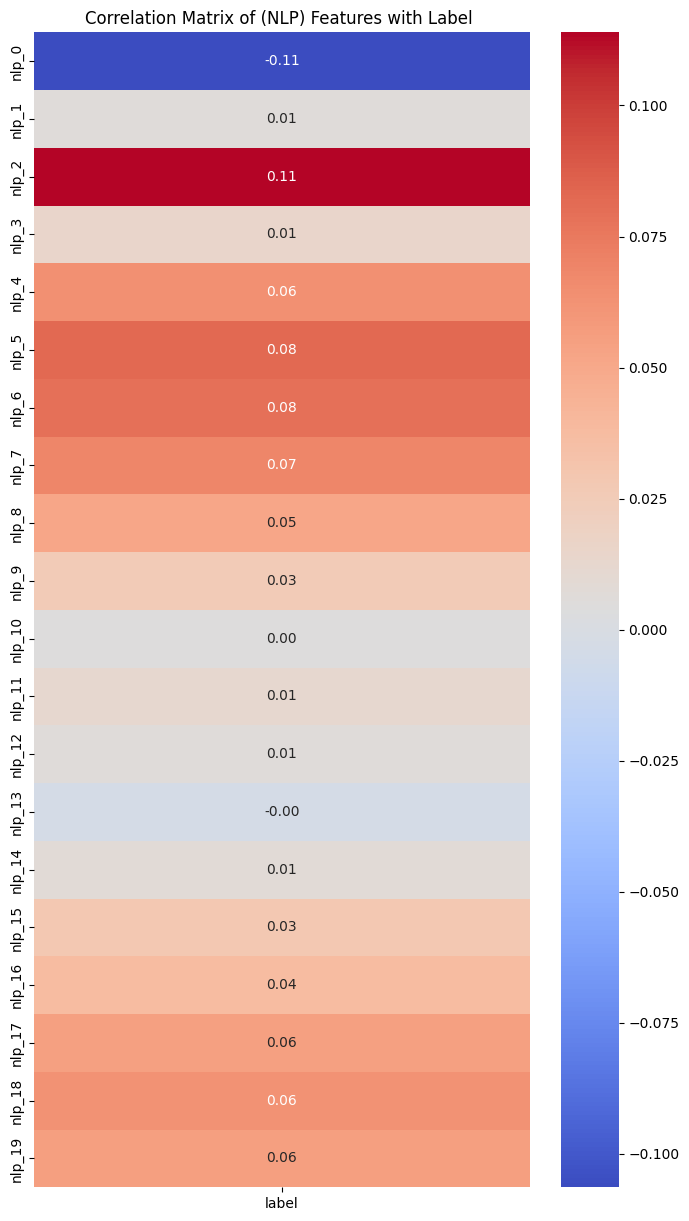

In [24]:
correlation_matrix = df_tokenizer_features.corr()

# Correlations with the label column
label_correlations = correlation_matrix.loc[:, ["label"]]
label_correlations = label_correlations.drop("label", axis=0)

plt.figure(figsize=(8, 15))
sns.heatmap(
    label_correlations, annot=True, fmt=".2f", cmap="coolwarm"
)
plt.title("Correlation Matrix of (NLP) Features with Label ")
plt.show()


In [25]:
df_tokenizer_features

,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9,nlp_10,nlp_11,nlp_12,nlp_13,nlp_14,nlp_15,nlp_16,nlp_17,nlp_18,nlp_19,label
0,6,1,2,1,1,1,59,48,1,16,9,1,1,1,1,0,0,0,0,0,0.0
1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
2,6,91,25,1,1,1,1,1,1,1,1,1,4,1,1,1,0,0,0,0,0.0
3,7,1,2,1,1,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
4,1,1,2,51,1,1,1,1,15,0,0,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120985,6,1,2,1,1,1,43,1,1,1,1,20,1,48,1,1,1,1,1,1,0.0
120986,7,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
120987,1,90,19,1,1,1,1,1,1,20,19,1,1,42,1,3,64,1,1,1,0.0
120988,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0


In [26]:
# save for testing model performance
df_tokenizer_features.to_csv("../notebooks/data/tokenizer_features.csv", index=False)

In [46]:
# Join df_features and df_tokenizer_features
df_combined_features = pd.concat(
    [df_features.drop("label", axis=1), df_tokenizer_features], axis=1
)

In [47]:
df_combined_features

,url_length,hostname_length,path_length,num_subdomains,domain_length,suffix_length,digit_density,letter_density,special_char_density,uppercase_density,lowercase_density,has_https,has_www,num_slashes,query_length,has_query,vowel_density,consonant_density,entropy,has_phishing_words,phishing_word_count,phishing_word_density,num_dashes,num_dots,num_at_symbols,num_and_symbols,num_equals_symbols,num_underscore_symbols,is_ip,has_port,has_fragment,has_params,has_username,has_password,has_hexadecimal,has_base64,has_unicode,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9,nlp_10,nlp_11,nlp_12,nlp_13,nlp_14,nlp_15,nlp_16,nlp_17,nlp_18,nlp_19,nlp_20,nlp_21,nlp_22,nlp_23,nlp_24,label
0,105,10,63,0,6,3,0.000000,0.847619,0.152381,0.133333,0.714286,0,0,6,24,1,0.266667,0.580952,3.327693,0,0,0.0,0,2,0,0,1,3,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0
1,37,0,37,2,4,3,0.000000,0.810811,0.189189,0.000000,0.810811,0,0,3,0,0,0.216216,0.594595,2.737380,0,0,0.0,0,3,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
2,131,6,118,0,3,2,0.061069,0.801527,0.137405,0.000000,0.801527,0,0,6,0,0,0.297710,0.503817,3.036428,0,0,0.0,10,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
3,52,0,52,1,5,3,0.211538,0.634615,0.153846,0.000000,0.634615,0,1,6,0,0,0.230769,0.403846,2.796498,0,0,0.0,0,2,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0
4,48,0,48,1,6,3,0.000000,0.833333,0.166667,0.083333,0.750000,0,0,3,0,0,0.312500,0.520833,3.015103,0,0,0.0,1,3,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120985,96,8,81,0,4,3,0.000000,0.770833,0.229167,0.000000,0.770833,0,0,5,0,0,0.218750,0.552083,2.953671,0,0,0.0,15,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0
120986,31,0,31,1,13,3,0.000000,0.903226,0.096774,0.000000,0.903226,0,1,1,0,0,0.387097,0.516129,2.712563,0,0,0.0,0,2,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0
120987,162,10,121,0,6,3,0.061728,0.771605,0.166667,0.037037,0.734568,1,0,4,22,1,0.271605,0.500000,3.209173,0,0,0.0,18,1,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0.0
120988,13,0,13,0,9,3,0.000000,0.923077,0.076923,0.000000,0.923077,0,0,0,0,0,0.384615,0.538462,2.458311,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0


In [48]:
df_combined_features.to_csv("../notebooks/data/combined_features.csv", index=False)